# Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from tqdm import tqdm  # This is not necessary but we added for the progress bar
from imblearn.over_sampling import SMOTE
import pickle

# Mounting Data from Drive

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Data

In [3]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")

train_df.head()

,desc_id,source_name,review_text,is_accessibility,cleanText,Vader Sentiment
0,1,gp_AOqpTOE-4PtpSwSKzv8CF6EtR6seFSLwg-QQPTpQKze...,Excellent app. Been using it for years on man...,Accessibility Review,excellent app using years many different phone...,Positive
1,1,gp_AOqpTOGPKJI_1QuwFgSTcvd7BanaHdhJoLUXZDx8OVt...,I've used this on a different phone - but cur...,Accessibility Review,used different phone currently moto android re...,Positive
2,1,lg_AOqpTOE5_m1p9SEdAbCNs_Nh_qN7EHMLnyPnytEW9NX...,Fantastic program! Instant search results and...,Accessibility Review,fantastic program instant search results fast ...,Positive
3,1,lg_AOqpTOEyZAX-Z1qAqVvbqV8s6vJAttZvFBFixQTM_jW...,I'm using this on my mobile as well as on PC ...,Accessibility Review,using mobile well view offline dictionaries us...,Positive
4,1,gp_AOqpTOE6SfnT_RCAb9w8AbMpASAbJDvsJIHxp_xuhKg...,Text reflow doesn't work. I want my money back...,Accessibility Review,text reflow work want money back,Positive


# Quick Data Analysis & Visualization

In [6]:
train_df.shape

(1985, 6)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   desc_id           1985 non-null   int64 
 1   source_name       1985 non-null   object
 2   review_text       1984 non-null   object
 3   is_accessibility  1985 non-null   object
 4   cleanText         1982 non-null   object
 5   Vader Sentiment   1985 non-null   object
dtypes: int64(1), object(5)
memory usage: 93.2+ KB


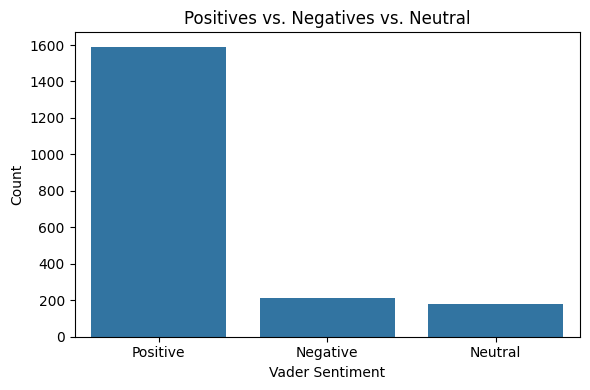

In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Vader Sentiment', data=train_df)
plt.title('Positives vs. Negatives vs. Neutral')
plt.xlabel('Vader Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Pre-Processing

# Drop rows where the 'vader sentiment' column is 'neutral'

In [13]:
train_df = train_df[train_df['Vader Sentiment'] != "Neutral"]

# Saving the cleaned dataset
train_df.to_csv("/content/drive/MyDrive/Colab Notebooks/cleaned_train.csv", index=False)



print("Rows after removing neutral sentiments:", len(train_df))
print(train_df['Vader Sentiment'].value_counts())
print("Neutral rows removed successfully!")

train_df.head(100)

Rows after removing neutral sentiments: 1804
Vader Sentiment
Positive    1590
Negative     214
Name: count, dtype: int64
Neutral rows removed successfully!


,desc_id,source_name,review_text,is_accessibility,cleanText,Vader Sentiment
0,1,gp_AOqpTOE-4PtpSwSKzv8CF6EtR6seFSLwg-QQPTpQKze...,Excellent app. Been using it for years on man...,Accessibility Review,excellent app using years many different phone...,Positive
1,1,gp_AOqpTOGPKJI_1QuwFgSTcvd7BanaHdhJoLUXZDx8OVt...,I've used this on a different phone - but cur...,Accessibility Review,used different phone currently moto android re...,Positive
2,1,lg_AOqpTOE5_m1p9SEdAbCNs_Nh_qN7EHMLnyPnytEW9NX...,Fantastic program! Instant search results and...,Accessibility Review,fantastic program instant search results fast ...,Positive
3,1,lg_AOqpTOEyZAX-Z1qAqVvbqV8s6vJAttZvFBFixQTM_jW...,I'm using this on my mobile as well as on PC ...,Accessibility Review,using mobile well view offline dictionaries us...,Positive
4,1,gp_AOqpTOE6SfnT_RCAb9w8AbMpASAbJDvsJIHxp_xuhKg...,Text reflow doesn't work. I want my money back...,Accessibility Review,text reflow work want money back,Positive
...,...,...,...,...,...,...
109,1,gp_AOqpTOHLMmleIDlZQNnU9zkNiTsqBiyyuXGuTNuwYt5...,Best ad blocker in the world but it MUST be ac...,Accessibility Review,best blocker world must accessible two browsers,Positive
110,1,gp_AOqpTOHmw4lRFSlqWmqF6vrOtMHfCYejSVJGg16akKW...,Amoled black theme please,Accessibility Review,amoled black theme please,Positive
111,1,gp_AOqpTOG05P6bOA1ydR_ProSM_QZoRcZ1iIYOPSh9Xee...,I like your Just Notes applications but I thin...,Accessibility Review,like notes applications think applications cou...,Positive
112,1,gp_AOqpTOE1R15VVjq3igH83s11zZ66OPdOxyaUOH5zRnC...,Can't you just hide the green preview of the ...,Accessibility Review,hide green preview sidebar sometimes obstructs...,Positive


# Oversampling to get balanced data

In [16]:
from imblearn.over_sampling import RandomOverSampler

# Load your dataset
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cleaned_train.csv")

# Separate the features and target variable
X = train_df.drop(columns=['Vader Sentiment'])
y = train_df['Vader Sentiment']

# Performing the oversampling using 'RandomOverSampler' - SMOTE didn't work for us
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Updating the dataframe with new balanced dataset
train_df = pd.concat([X_resampled, y_resampled], axis=1)

# Saving the balanced dataset again
train_df.to_csv("/content/drive/MyDrive/Colab Notebooks/cleaned_train.csv", index=False)

print("Balanced dataset saved successfully!")

Balanced dataset saved successfully!


In [18]:
#Loading the updated dataset
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cleaned_train.csv")
train_df

,desc_id,source_name,review_text,is_accessibility,cleanText,Vader Sentiment
0,1,gp_AOqpTOE-4PtpSwSKzv8CF6EtR6seFSLwg-QQPTpQKze...,Excellent app. Been using it for years on man...,Accessibility Review,excellent app using years many different phone...,Positive
1,1,gp_AOqpTOGPKJI_1QuwFgSTcvd7BanaHdhJoLUXZDx8OVt...,I've used this on a different phone - but cur...,Accessibility Review,used different phone currently moto android re...,Positive
2,1,lg_AOqpTOE5_m1p9SEdAbCNs_Nh_qN7EHMLnyPnytEW9NX...,Fantastic program! Instant search results and...,Accessibility Review,fantastic program instant search results fast ...,Positive
3,1,lg_AOqpTOEyZAX-Z1qAqVvbqV8s6vJAttZvFBFixQTM_jW...,I'm using this on my mobile as well as on PC ...,Accessibility Review,using mobile well view offline dictionaries us...,Positive
4,1,gp_AOqpTOE6SfnT_RCAb9w8AbMpASAbJDvsJIHxp_xuhKg...,Text reflow doesn't work. I want my money back...,Accessibility Review,text reflow work want money back,Positive
...,...,...,...,...,...,...
3175,1,gp_AOqpTOF071lipLPfUBJdcVLzE8igfZ5SpVJH_yHzVI6...,It's ok does not zoom on my galaxy S 4 makes ...,Accessibility Review,zoom galaxy makes really hard read need magnif...,Negative
3176,1,gp_AOqpTOGntG02hpvWsJyqwEZX-gW1G0qyv7sTAKCy70s...,Works as advertised - but missing some notable...,Accessibility Review,works advertised missing notable features comi...,Negative
3177,1,lg_AOqpTOFxw3pHVKLbRL85j3aXs7JKmprgddxOKBO5Yco...,Alarm volume fade doesn't work,Accessibility Review,alarm volume fade work,Negative
3178,1,gp_AOqpTOHJfraYstFRM01yKI_V0GxM69nWxUGEzGaP6lx...,The latest update has stopped rendering any ma...,Accessibility Review,latest update stopped rendering map zoom enoug...,Negative


# Visualizing the balanced data

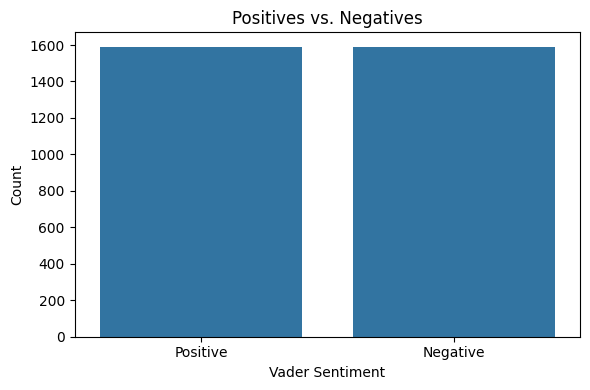

In [21]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Vader Sentiment', data=train_df)
plt.title('Positives vs. Negatives')
plt.xlabel('Vader Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1])
plt.tight_layout()
plt.show()

# Vader Lexicon

In [26]:
import re

def simple_tokenizer(text):
    """
    Tokenizes a sentence by splitting on spaces and punctuation.
    This is a fallback when nltk.word_tokenize() doesn't work.
    """
    return re.findall(r'\b\w+\b', text.lower())  # Extract words, ignore punctuation

# Example
text = "I really love this amazing product!"
tokens = simple_tokenizer(text)
print(tokens)


['i', 'really', 'love', 'this', 'amazing', 'product']


In [28]:
# This is to determine the maximum length of reviews
train_df['review_length'] = train_df['cleanText'].apply(lambda x: len(simple_tokenizer(x)))
max_length = train_df['review_length'].max()
print(f"Maximum review length: {max_length}")

Maximum review length: 236


In [30]:
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

import re
def simple_tokenizer(text):
    return re.findall(r'\b\w+\b', text.lower())

# Turning sentences to vader number sequences
def sentence_to_vader_sequence(sentence, max_length=max_length):
    words = simple_tokenizer(sentence)
    vaderLex = analyzer.lexicon
    scores = [vaderLex.get(word.lower(), 0) for word in words]

    # We're Padding with 0s to ensure fixed length
    scores.extend([0] * (max_length - len(scores)))
    return scores[:max_length]

# Example
print(sentence_to_vader_sequence("I love this amazing product!"))


[0, 3.2, 0, 2.8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[nltk_data] Downloading package vader_lexicon to C:\Users\RIHAB-
[nltk_data]     PC/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [31]:
# Calling teh previously defined function to turn reviews into Vader number sequence
train_df['vader_sequence'] = train_df['cleanText'].apply(lambda x: sentence_to_vader_sequence(x))

print(train_df[['cleanText', 'vader_sequence']].head())

# Convert sentiment to binary (positive -> 1, negative -> 0)
train_df['Vader Sentiment'] = train_df['Vader Sentiment'].replace({'Positive': 1, 'Negative': 0}).astype(int)

# Save the new dataset with VADER features
train_df.to_csv("/content/drive/MyDrive/Colab Notebooks/cleaned_train.csv", index=False)


                                              cleanText  \
1027  recent update completely killed zooming issues...   
1503  please add edge width none option zoom fit hei...   
785   great start really looking forward future impr...   
411   caused pain head seizures issues mess seizure ...   
1103                        simple understandable clean   

                                         vader_sequence  
1027  [0, 0, 0, -3.5, 0, 0, 1.4, 1.9, 1.8, 0, 0, 0, ...  
1503  [1.3, 0, 0, 0, 0, 0, 0, 1.5, 0, 0, -1.9, -1.4,...  
785   [3.1, 0, 0, 0, 0, 0, 1.3, 1.3, 0, 0, 0, 1.8, 0...  
411   [0, -2.3, 0, 0, 0, -1.5, 0, 2.3, 0, 0, 0, 0, -...  
1103  [0, 0, 1.7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  


C:\Users\RIHAB-PC\AppData\Local\Temp\ipykernel_21184\1372030119.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['Vader Sentiment'] = train_df['Vader Sentiment'].replace({'Positive': 1, 'Negative': 0}).astype(int)


In [34]:
train_df.head(100)

,desc_id,source_name,review_text,is_accessibility,cleanText,Vader Sentiment,review_length,vader_sequence
1027,1,lg_AOqpTOFbI7eANjUPH5gx8FrO7lY-ewnoaBpkY3cb_c0...,The most recent update completely killed it w...,Accessibility Review,recent update completely killed zooming issues...,1,29,"[0, 0, 0, -3.5, 0, 0, 1.4, 1.9, 1.8, 0, 0, 0, ..."
1503,1,gp_AOqpTOEaJC0dt4Y5CKXZkxYG3e2mNXqiivAUDLfY6nP...,Please add Edge Width = None option - Zoom = F...,Accessibility Review,please add edge width none option zoom fit hei...,0,31,"[1.3, 0, 0, 0, 0, 0, 0, 1.5, 0, 0, -1.9, -1.4,..."
785,1,gp_AOqpTOFKwCeAxILja3_VtrZMcH_2Ni-2iGQzJhxC4m1...,This is a great start and I'm really looking f...,Accessibility Review,great start really looking forward future impr...,1,58,"[3.1, 0, 0, 0, 0, 0, 1.3, 1.3, 0, 0, 0, 1.8, 0..."
411,1,lg_AOqpTOEZ1YpFIWGESAYbClUkrAjqIvWjiuWU7SImAOl...,Caused pain in my head. I do have seizures iss...,Accessibility Review,caused pain head seizures issues mess seizure ...,0,17,"[0, -2.3, 0, 0, 0, -1.5, 0, 2.3, 0, 0, 0, 0, -..."
1103,1,gp_AOqpTOEq8l2y_jiFNSn89epNonK0-QEoKG91xAg68Dz...,Simple - understandable - and clean.,Accessibility Review,simple understandable clean,1,3,"[0, 0, 1.7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
...,...,...,...,...,...,...,...,...
3034,1,lg_AOqpTOFJhAeNb2wYG4TwYc409rxZOmGRBtrUyF8yWqm...,The zoom gets stuck and the puzzle becomes to...,Accessibility Review,zoom gets stuck puzzle becomes small see,0,7,"[0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
44,1,gp_AOqpTOH7KBuBzFOua-5Ox0VsE3JzAtf9_fSHReUtKFB...,Ads in the way can't see whole documents. Sux,Accessibility Review,ads way see whole documents sux,0,6,"[0, 0, 0, 0, 0, -1.5, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2746,1,lg_AOqpTOEi7YVHXMyq3jtQTA6H-hz0ObWS2Y6FVfWhTP4...,I've had this app for years on other phones b...,Accessibility Review,app years phones also zooming problem made alm...,0,12,"[0, 0, 0, 0, 0, -1.7, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1867,1,gp_AOqpTOGSKVIIEmoxFWzxYjbNP8-k3UEUTvzflwc64u2...,Only missing a dark theme for the main view. ...,Accessibility Review,missing dark theme main view otherwise absolut...,0,11,"[-1.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [36]:
print(train_df['Vader Sentiment'])  # Should only show [0, 1]

1027    1
1503    0
785     1
411     0
1103    1
       ..
1095    1
1130    1
1294    1
860     1
3174    0
Name: Vader Sentiment, Length: 3180, dtype: int32


# Dropping unnecessary columns: 'desc_id', 'source_name', 'review_text', and 'is_accessibility', 'review_length'


In [39]:
train_df.drop(columns=['desc_id', 'source_name', 'review_text', 'is_accessibility', 'review_length'], inplace=True)

# Saving the cleaned dataset
train_df.to_csv("/content/drive/MyDrive/Colab Notebooks/cleaned_train.csv", index=False)

# Load the new clean dataset
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cleaned_train.csv")

In [41]:
 train_df.head()

,cleanText,Vader Sentiment,vader_sequence
0,recent update completely killed zooming issues...,1,"[0, 0, 0, -3.5, 0, 0, 1.4, 1.9, 1.8, 0, 0, 0, ..."
1,please add edge width none option zoom fit hei...,0,"[1.3, 0, 0, 0, 0, 0, 0, 1.5, 0, 0, -1.9, -1.4,..."
2,great start really looking forward future impr...,1,"[3.1, 0, 0, 0, 0, 0, 1.3, 1.3, 0, 0, 0, 1.8, 0..."
3,caused pain head seizures issues mess seizure ...,0,"[0, -2.3, 0, 0, 0, -1.5, 0, 2.3, 0, 0, 0, 0, -..."
4,simple understandable clean,1,"[0, 0, 1.7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


# Metrics

In [44]:
def compute_accuracy(y_true, y_pred):
    y_pred_labels = (y_pred >= 0.5).astype(int)
    return np.mean(y_true == y_pred_labels)

In [46]:
def precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

In [48]:
def recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

In [50]:
def f1_score(precision, recall):
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

# Linear regression & Gradient Descent

In [53]:
# Loading updated dataset
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cleaned_train.csv")

In [55]:
import ast

if isinstance(train_df['vader_sequence'].iloc[0], str):
    train_df['vader_sequence'] = train_df['vader_sequence'].apply(ast.literal_eval)

# Extracting sequence_sequence feature into X
# Converting from list of lists to NumPy array
X = np.array(train_df['vader_sequence'].tolist(), dtype=float)

# Ensuring correct shape
if len(X.shape) == 1:
    X = X.reshape(-1, len(X[0]))  # Reshaping from (samples,) to (samples, features) because we were getting errors on it

In [56]:
print("X shape:", X.shape)
print("First few values of X:", X[:5])

X shape: (3180, 236)
First few values of X: [[ 0.   0.   0.  ...  0.   0.   0. ]
 [ 1.3  0.   0.  ...  0.   0.   0. ]
 [ 3.1  0.   0.  ...  0.   0.   0. ]
 [ 0.  -2.3  0.  ...  0.   0.   0. ]
 [ 0.   0.   1.7 ...  0.   0.   0. ]]


In [57]:
# Extracting target labels into Y
Y = train_df['Vader Sentiment'].values.reshape(-1, 1)

In [58]:
print("Y shape:", Y.shape)
print("First few values of Y:", Y[:5])

Y shape: (3180, 1)
First few values of Y: [[1]
 [0]
 [1]
 [0]
 [1]]


In [63]:
# Split into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [65]:
# Initializing weights and bias
def initialize(dim):
    w = np.zeros(shape=(dim, 1), dtype=float)  # Weight sequence (features x 1)
    b = 0  # Bias
    return w, b

In [67]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [69]:
def forward_propagation(X, w, b):
    z = np.dot(X, w) + b
    A = sigmoid(z)
    return A

In [71]:
# (Binary Cross-Entropy Loss)
def compute_cost(Y, A, m):
    epsilon = 1e-10
    A = np.clip(A, epsilon, 1 - epsilon)  # Ensure A is never exactly 0 or 1
    return -(1/m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))

In [73]:
def compute_gradients(X, Y, A, m):
    dz = A - Y
    dw = (1/m) * np.dot(X.T, dz)
    db = (1/m) * np.sum(dz)
    return dw, db

In [75]:
def compute_accuracy(Y, A):
    predictions = (A >= 0.5).astype(int)  # Apply threshold (0.5)
    return np.mean(predictions == Y) * 100  # Accuracy in %

In [77]:
# Logistic regression training function
def model(w, b, X_train, Y_train, X_val, Y_val, epochs, alpha):
    cost_history_train = []
    cost_history_val = []
    accuracy_history_train = []
    accuracy_history_val = []

    m = X_train.shape[0]  # Ps: Number of training samples

    for i in range(epochs):
        # Forward propagation
        A_train = forward_propagation(X_train, w, b)
        cost_train = compute_cost(Y_train, A_train, m)
        dw, db = compute_gradients(X_train, Y_train, A_train, m)

        # Update weights
        w -= alpha * dw
        b -= alpha * db

        # Store cost and accuracy
        cost_history_train.append(cost_train)
        accuracy_history_train.append(compute_accuracy(Y_train, A_train))

        # Validate model
        A_val = forward_propagation(X_val, w, b)
        cost_val = compute_cost(Y_val, A_val, X_val.shape[0])
        cost_history_val.append(cost_val)
        accuracy_history_val.append(compute_accuracy(Y_val, A_val))

        if i % 100 == 0:
            print(f"Epoch {i}: Train Cost = {cost_train:.4f}, Val Cost = {cost_val:.4f}, Train Acc = {accuracy_history_train[-1]:.2f}%, Val Acc = {accuracy_history_val[-1]:.2f}%")

    return w, b, cost_history_train, cost_history_val, accuracy_history_train, accuracy_history_val

In [79]:
# Training logistic regression model
dim = X_train.shape[1]  # Ps: Number of features
w, b = initialize(dim)

In [81]:
epochs = 4000
alpha = 0.050

In [83]:
w, b, cost_history_train, cost_history_val, accuracy_history_train, accuracy_history_val = model(w, b, X_train, Y_train, X_val, Y_val, epochs, alpha)

Epoch 0: Train Cost = 0.6931, Val Cost = 0.6852, Train Acc = 50.00%, Val Acc = 90.09%
Epoch 100: Train Cost = 0.4242, Val Cost = 0.3972, Train Acc = 89.86%, Val Acc = 92.61%
Epoch 200: Train Cost = 0.3472, Val Cost = 0.3172, Train Acc = 90.33%, Val Acc = 92.30%
Epoch 300: Train Cost = 0.3065, Val Cost = 0.2761, Train Acc = 91.08%, Val Acc = 92.45%
Epoch 400: Train Cost = 0.2804, Val Cost = 0.2505, Train Acc = 91.59%, Val Acc = 92.61%
Epoch 500: Train Cost = 0.2618, Val Cost = 0.2328, Train Acc = 91.71%, Val Acc = 92.45%
Epoch 600: Train Cost = 0.2476, Val Cost = 0.2198, Train Acc = 92.14%, Val Acc = 92.77%
Epoch 700: Train Cost = 0.2363, Val Cost = 0.2097, Train Acc = 92.65%, Val Acc = 93.08%
Epoch 800: Train Cost = 0.2270, Val Cost = 0.2016, Train Acc = 92.85%, Val Acc = 93.08%
Epoch 900: Train Cost = 0.2193, Val Cost = 0.1949, Train Acc = 93.12%, Val Acc = 93.55%
Epoch 1000: Train Cost = 0.2127, Val Cost = 0.1893, Train Acc = 93.12%, Val Acc = 93.71%
Epoch 1100: Train Cost = 0.2069, 

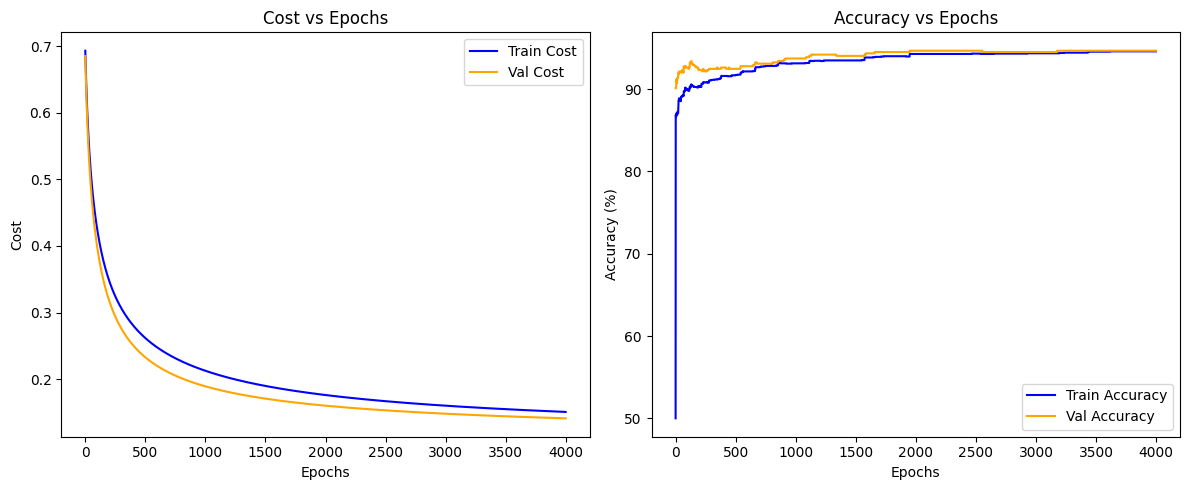

In [84]:
plt.figure(figsize=(12, 5))

# Cost
plt.subplot(1, 2, 1)
plt.plot(range(len(cost_history_train)), cost_history_train, label='Train Cost', color='blue')
plt.plot(range(len(cost_history_val)), cost_history_val, label='Val Cost', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost vs Epochs')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracy_history_train)), accuracy_history_train, label='Train Accuracy', color='blue')
plt.plot(range(len(accuracy_history_val)), accuracy_history_val, label='Val Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 0: Train Cost = 0.6931, Val Cost = 0.5949, Train Acc = 50.00%, Val Acc = 90.09%
Epoch 100: Train Cost = 0.1930, Val Cost = 0.1729, Train Acc = 93.47%, Val Acc = 94.03%
Epoch 200: Train Cost = 0.1625, Val Cost = 0.1498, Train Acc = 94.30%, Val Acc = 94.50%
Epoch 300: Train Cost = 0.1494, Val Cost = 0.1401, Train Acc = 94.77%, Val Acc = 94.65%
Epoch 400: Train Cost = 0.1416, Val Cost = 0.1344, Train Acc = 94.93%, Val Acc = 94.81%
Epoch 500: Train Cost = 0.1365, Val Cost = 0.1306, Train Acc = 95.01%, Val Acc = 94.97%
Epoch 600: Train Cost = 0.1327, Val Cost = 0.1278, Train Acc = 95.09%, Val Acc = 95.28%
Epoch 700: Train Cost = 0.1298, Val Cost = 0.1258, Train Acc = 95.09%, Val Acc = 95.44%
Epoch 800: Train Cost = 0.1275, Val Cost = 0.1241, Train Acc = 95.24%, Val Acc = 95.75%
Epoch 900: Train Cost = 0.1256, Val Cost = 0.1228, Train Acc = 95.36%, Val Acc = 95.75%
Epoch 1000: Train Cost = 0.1240, Val Cost = 0.1217, Train Acc = 95.40%, Val Acc = 95.75%
Epoch 1100: Train Cost = 0.1227, 

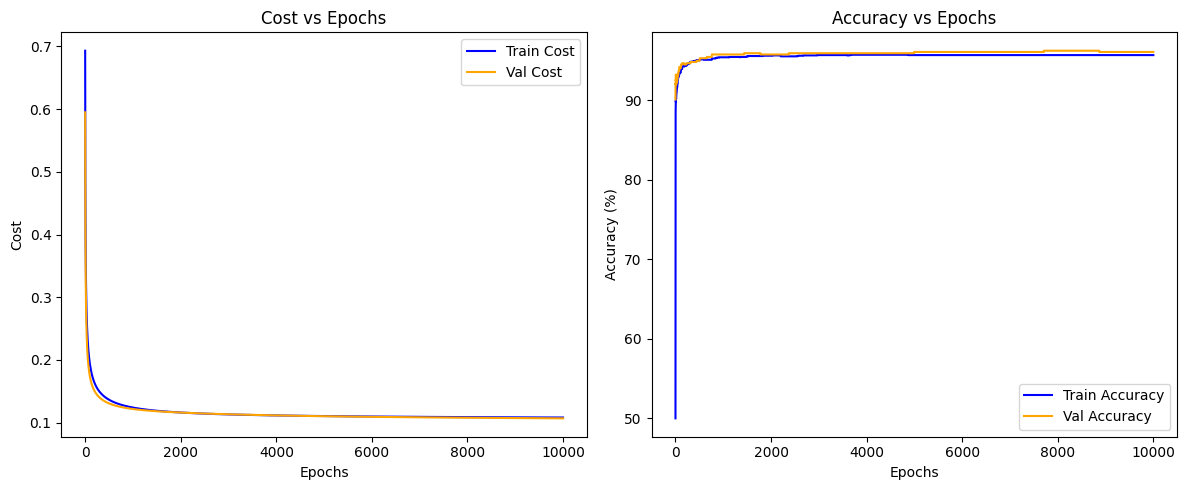

In [87]:
del w, b  # Delete previous weights and bias
w, b = initialize(X_train.shape[1])  # Reinitialize them
# Because otherwise it was just taking over where it left

epochs = 10000
alpha = 0.7

w2, b2, cost_history_train, cost_history_val, accuracy_history_train, accuracy_history_val = model(w, b, X_train, Y_train, X_val, Y_val, epochs, alpha)

plt.figure(figsize=(12, 5))
# Cost
plt.subplot(1, 2, 1)
plt.plot(range(len(cost_history_train)), cost_history_train, label='Train Cost', color='blue')
plt.plot(range(len(cost_history_val)), cost_history_val, label='Val Cost', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost vs Epochs')
plt.legend()
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracy_history_train)), accuracy_history_train, label='Train Accuracy', color='blue')
plt.plot(range(len(accuracy_history_val)), accuracy_history_val, label='Val Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 0: Train Cost = 0.6931, Val Cost = 0.5949, Train Acc = 50.00%, Val Acc = 90.09%
Epoch 100: Train Cost = 0.1930, Val Cost = 0.1729, Train Acc = 93.47%, Val Acc = 94.03%
Epoch 200: Train Cost = 0.1625, Val Cost = 0.1498, Train Acc = 94.30%, Val Acc = 94.50%
Epoch 300: Train Cost = 0.1494, Val Cost = 0.1401, Train Acc = 94.77%, Val Acc = 94.65%
Epoch 400: Train Cost = 0.1416, Val Cost = 0.1344, Train Acc = 94.93%, Val Acc = 94.81%
Epoch 500: Train Cost = 0.1365, Val Cost = 0.1306, Train Acc = 95.01%, Val Acc = 94.97%
Epoch 600: Train Cost = 0.1327, Val Cost = 0.1278, Train Acc = 95.09%, Val Acc = 95.28%
Epoch 700: Train Cost = 0.1298, Val Cost = 0.1258, Train Acc = 95.09%, Val Acc = 95.44%
Epoch 800: Train Cost = 0.1275, Val Cost = 0.1241, Train Acc = 95.24%, Val Acc = 95.75%
Epoch 900: Train Cost = 0.1256, Val Cost = 0.1228, Train Acc = 95.36%, Val Acc = 95.75%
Epoch 1000: Train Cost = 0.1240, Val Cost = 0.1217, Train Acc = 95.40%, Val Acc = 95.75%
Epoch 1100: Train Cost = 0.1227, 

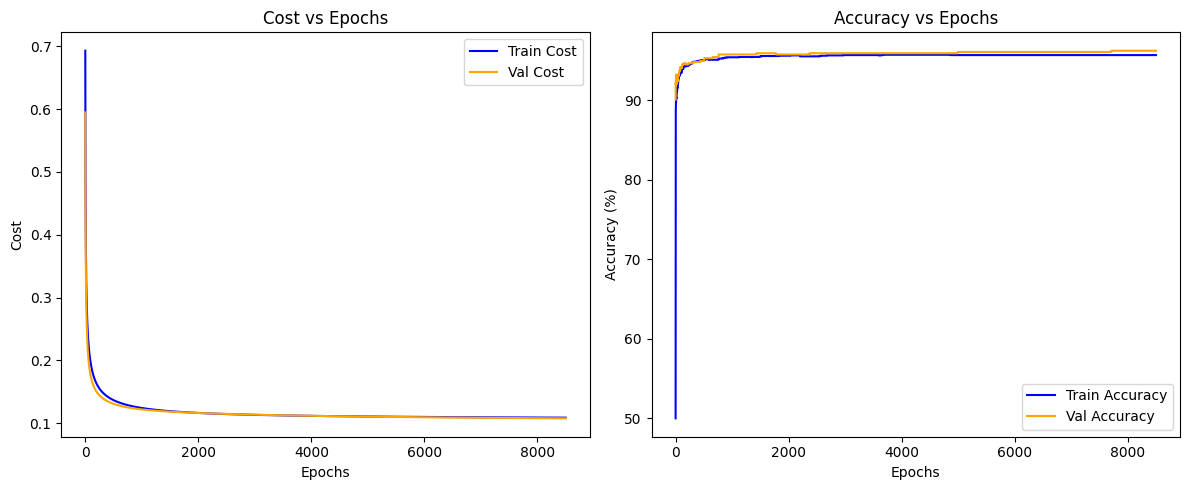

In [88]:
del w, b
w, b = initialize(X_train.shape[1])

epochs = 8500
alpha = 0.7

w3, b3, cost_history_train, cost_history_val, accuracy_history_train, accuracy_history_val = model(w, b, X_train, Y_train, X_val, Y_val, epochs, alpha)

plt.figure(figsize=(12, 5))
# Cost
plt.subplot(1, 2, 1)
plt.plot(range(len(cost_history_train)), cost_history_train, label='Train Cost', color='blue')
plt.plot(range(len(cost_history_val)), cost_history_val, label='Val Cost', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost vs Epochs')
plt.legend()
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracy_history_train)), accuracy_history_train, label='Train Accuracy', color='blue')
plt.plot(range(len(accuracy_history_val)), accuracy_history_val, label='Val Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Saving Model

In [91]:
with open("logistic_regression_model3.pkl", "wb") as file:
    pickle.dump((w3, b3), file)

# Loading Model

In [96]:
with open("logistic_regression_model3.pkl", "rb") as file:
    w, b = pickle.load(file)

# Formatting the test set like the training set

In [110]:
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")

In [112]:
test_df.head()

,desc_id,source_name,review_text,is_accessibility,cleanText
0,1,gp_AOqpTOGrphtVjrB_Udf0Mg-Fb_uFHMpCJyxMRPGZvwk...,I have a problem with your app. Running the l...,Accessibility Review,problem app running last version app google pl...
1,1,gp_AOqpTOGscxyOhbcCo0Lgj-cyvdO5VJRPgRg42S4gr1-...,I've been using this app for a few weeks now ...,Accessibility Review,using app weeks everything great today suddenl...
2,1,gp_AOqpTOGTbz6wfmSUzPTxKdubTzn3tVx00D9GU6yxuTs...,I prefer Cool Reader (CR) to Aldiko. CR chang...,Accessibility Review,prefer cool reader aldiko changes pages swipe ...
3,1,gp_AOqpTOGU444Ao-q5YbeX4g4jiml1NX999cK-7O53aqa...,Missing the ability to invert colour of images...,Accessibility Review,missing ability invert colour images night mod...
4,1,gp_AOqpTOGUA3EUD0njqe8phB4M0CCo3N4cHDsYeU2N6dG...,Cool Reader allows more customizations than ha...,Accessibility Review,cool reader allows customizations ever seen ep...


In [114]:
test_df['vader_sequence'] = test_df['cleanText'].apply(sentence_to_vader_sequence)

X_test = np.array(test_df['vader_sequence'].tolist(), dtype=float)


In [116]:
test_df.drop(columns=['desc_id', 'source_name', 'review_text', 'is_accessibility'], inplace=True)

In [118]:
test_df.head()

,cleanText,vader_sequence
0,problem app running last version app google pl...,"[-1.7, 0, 0, 0, 0, 0, 0, 1.4, 0, 0, 0, 0, 0, 0..."
1,using app weeks everything great today suddenl...,"[0, 0, 0, 0, 3.1, 0, 0, 0, 0, 0, 0, 0, 0, 1.3,..."
2,prefer cool reader aldiko changes pages swipe ...,"[0, 1.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,missing ability invert colour images night mod...,"[-1.2, 1.3, 0, 0, 0, 0, 0, 0, 1.9, 0, 3.2, 0, ..."
4,cool reader allows customizations ever seen ep...,"[1.3, 0, 0, 0, 0, 0, 0, 0, 0, 1.3, 0, 0, 0, 0,..."


# Prediction & Evaluation

In [121]:
# Forward propagation to get probabilities
A_test = forward_propagation(X_test, w, b)

test_predictions = (A_test >= 0.5).astype(int)


In [123]:
# numbering each row
submission_df = pd.DataFrame({
    'id': range(len(test_df)),
    'Vader_Binary_Sentiment': test_predictions.flatten()  # Converts array to column
})

submission_df.to_csv("/content/drive/MyDrive/Colab Notebooks/submission.csv", index=False)

print("Submission file saved !")


Submission file saved !
